In [9]:
import numpy as np
import networkx as nx
from scipy.optimize import minimize
from matplotlib import pyplot as plt
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-05-03 03:16:32,237: Credentials are already in use. The existing account in the session will be replaced.


In [10]:
def get_maxcut_ansatz(graph, params):
    # Prepare the circuit ansatz.
    n_vertices = 1 + max([max(e) for e in graph.edges])
    qaoa = QuantumCircuit(n_vertices)
    p = len(params)//2
    alpha = params[:p]
    beta = params[p:]
    # (1) Place all qubits into equal superposition.
    for i in range(n_vertices):
        qaoa.h(i)
    # (2) Arrange layers of alternating rotations.
    for layer in range(p):
        for q1, q2 in graph.edges:
            qaoa.cx(q1, q2)
            qaoa.rz(alpha[layer], q2)
            qaoa.cx(q1, q2)
        for i in range(n_vertices):
            qaoa.rx(beta[layer], i)
    qaoa.measure_all()
    return qaoa

In [34]:
def get_maxcut_singlerun_objective(graph, bit_string):
    obj = 0
    for q1, q2 in graph.edges:
        obj -= (bit_string[q1] != bit_string[q2])
    return obj

def get_maxcut_energy(graph, counts):
    avg_obj = 0.0
    total_count = 0
    for bit_string in counts:
        avg_obj += counts[bit_string] * get_maxcut_singlerun_objective(graph, bit_string[::-1])
        total_count += counts[bit_string]
    avg_obj /= total_count
    return avg_obj
        
def get_maxcut_total_objective(graph, params, 
                               backend = Aer.get_backend('qasm_simulator'), n_shots=1000):
    maxcut_ansatz = get_maxcut_ansatz(graph, params)
    job = execute(maxcut_ansatz, backend=backend, shots=n_shots)
    result = job.result()
    return get_maxcut_energy(graph, result.get_counts(maxcut_ansatz))

In [47]:
def optimize_maxcut(graph, params, backend = Aer.get_backend('qasm_simulator'), 
                    iterations = 2000, shots_per_iter = 1000):
    p = len(params)//2
    result = minimize(
        lambda angles: get_maxcut_total_objective(graph, angles, backend, n_shots = shots_per_iter),
                         params, method = 'COBYLA', options = {'maxiter': iterations}
    )
    alpha = result['x'][:p]
    beta = result['x'][p:]
    opt_circuit = get_maxcut_ansatz(graph, params)
    opt_counts = execute(opt_circuit, backend=backend, shots=iterations).result() \
                                                                        .get_counts(opt_circuit)
    opt_bitstring = max(opt_counts, key=opt_counts.get)
    return {'best_partition': opt_bitstring[::-1], 
            'best_cut_value': -get_maxcut_singlerun_objective(graph, opt_bitstring[::-1]), 
            'full_counts': opt_counts}

def draw_maxcut_result(G, partition):
    nx.draw(G, with_labels=True, node_color=[('red' if i == '0' else 'blue') for i in partition])

In [13]:
def brute_force_maxcut(graph):
    n_vertices = 1 + max([max(e) for e in graph.edges])
    partition = 0
    best_partition = -1
    best_cut = -1
    while (partition < 2**n_vertices):
        binary_partition = ''.join(
            [str(1 if partition & 2**i > 0 else 0) for i in range(n_vertices)]
        )
        new_cut = -get_maxcut_singlerun_objective(graph, binary_partition)
        if (best_cut < new_cut):
            best_partition = partition
            best_cut = new_cut
        partition += 1
    return ''.join(
        [str(1 if best_partition & 2**i > 0 else 0) for i in range(n_vertices)]
    ), best_cut

def random_graph(n_vertices, p=0.1):
    G = nx.Graph()
    for i in range(n_vertices):
        for j in range(i+1, n_vertices):
            if (np.random.random() < p):
                G.add_edge(i, j)
    return G

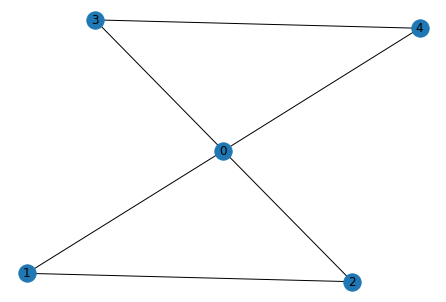

In [6]:
G1 = nx.Graph()
G1.add_edges_from([[0, 1], [0, 2], [1, 2], [0, 3], [0, 4], [3, 4]])
nx.draw(G1, with_labels=True)

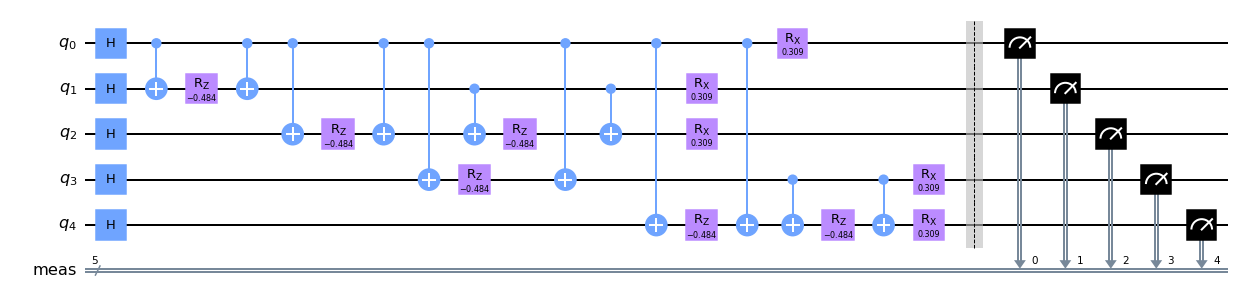

In [31]:
get_maxcut_ansatz(G1, np.random.randn(2)).draw() # p = 1 circuit

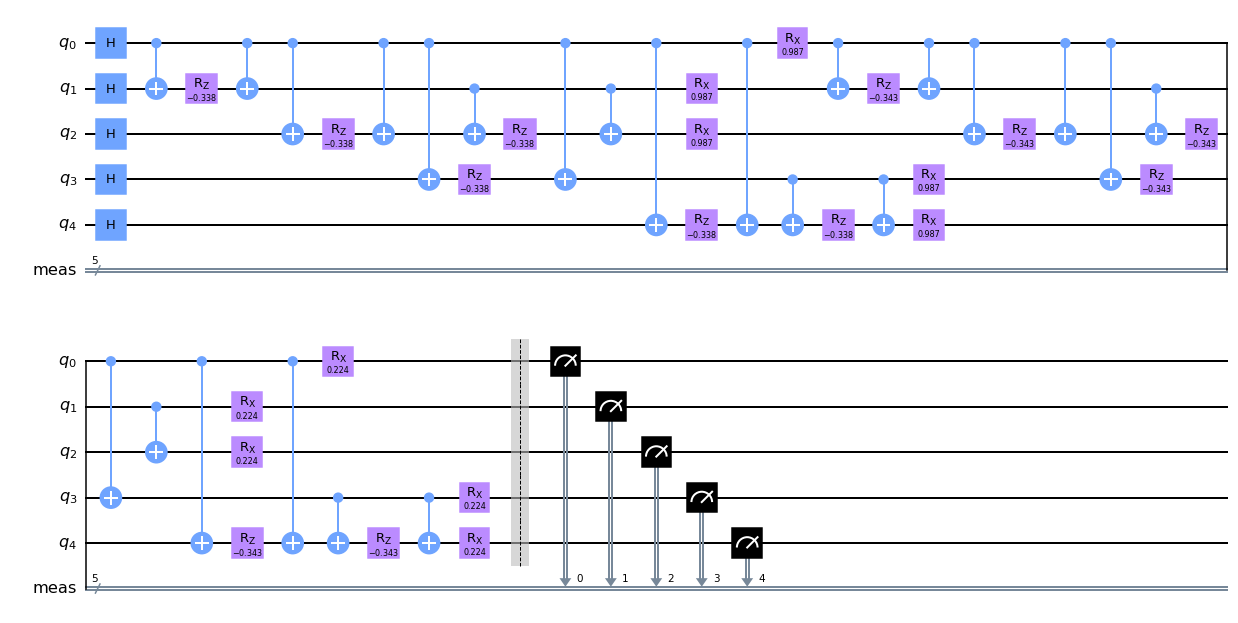

In [32]:
get_maxcut_ansatz(G1, np.random.randn(4)).draw() # p = 2 circuit

In [25]:
# Simulated in QASM 
for p in [1, 2]:
    params = np.random.randn(2 * p) * 0.01
    print(params)
    result = optimize_maxcut(G1, params)
    print('Partition', result['best_partition'], 'yields a cut of', result['best_cut_value'], '.')
print('Maximum possible was', brute_force_maxcut(G1))

[0.0075893  0.01376599]
Partition 01010 yields a cut of 4 .
[ 0.0054002   0.00745086 -0.01212842  0.00220378]
Partition 11010 yields a cut of 4 .
Maximum possible was ('10000', 4)


In [48]:
# Run on real quantum computers
for p in [1, 2]:
    params = np.random.randn(2 * p) * 0.01
    print(params)
    result = optimize_maxcut(G1, params, backend = provider.get_backend('ibmq_santiago'))
    print('Partition', result['best_partition'], 'yields a cut of', result['best_cut_value'], '.')
print('Maximum possible was', brute_force_maxcut(G1))

[-0.01416006  0.00478535]
Partition 00000 yields a cut of 0 .
[ 0.00116755  0.01127644  0.02689316 -0.00082239]
Partition 00000 yields a cut of 0 .
Maximum possible was ('10000', 4)


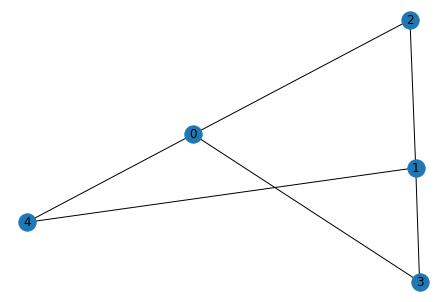

In [7]:
G2 = nx.Graph()
G2.add_edges_from([[0, 2], [0, 3], [0, 4], [1, 2], [1, 3], [1, 4]])
nx.draw(G2, with_labels=True)

In [25]:
# Simulated in QASM 
for p in [1, 2]:
    params = np.random.randn(2 * p) * 0.01
    print(params)
    result = optimize_maxcut(G2, params)
    print('Partition', result['best_partition'], 'yields a cut of', result['best_cut_value'], '.')
print('Maximum possible was', brute_force_maxcut(G2))

[0.00386693 0.00668946]
Partition 01001 yields a cut of 3 .
[ 0.00103836  0.00865153 -0.02896148  0.01090139]
Partition 11000 yields a cut of 6 .
Maximum possible was ('11000', 6)


In [37]:
# Run on real quantum computers
for p in [1, 2]:
    params = np.random.randn(2 * p) * 0.01
    print(params)
    result = optimize_maxcut(G2, params, backend = provider.get_backend('ibmq_santiago'))
    print('Partition', result['best_partition'], 'yields a cut of', result['best_cut_value'], '.')
print('Maximum possible was', brute_force_maxcut(G2))

[ 0.00187634 -0.00161662]
Partition 00101 yields a cut of 4 .
[0.00387957 0.00633073 0.00377526 0.01256322]
Partition 00011 yields a cut of 4 .
Maximum possible was ('11000', 6)
